In [104]:
import scirpy as ir
import muon as mu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Query epitope databases
- we query reference databases or datasets to annotate IRs with certain features, such as epitope specificity.

**Databases**
- [VDJdb](https://vdjdb.cdr3.net/), a curated database of T-cell receptor (TCR) sequences with known antigen specificities.
- [IEDB](https://academic.oup.com/nar/article/47/D1/D339/5144151?login=false): immune epitope data related to all species studied and includes antibody, T cell, and MHC binding contexts associated with infectious, allergic, autoimmune, and transplant related diseases. 

In [105]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu("../data/tcr_data/121c_clone_id_full.h5mu")

In [106]:
iedb = ir.datasets.iedb()
vdjdb = ir.datasets.vdjdb()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## VDJDB

In [107]:
# Calculate the immune receptor distance between samples in 'mdata' and 'vdjdb' databases.
# The distance is calculated based on the identity metric for amino acid sequences ('aa').
ir.pp.ir_dist(mdata, vdjdb, metric="identity", sequence="aa", inplace=True)

# # Perform an immune receptor query on 'mdata' against the 'vdjdb' database.
# # The query uses the identity metric and focuses on amino acid sequences ('aa').
# # It considers any receptor arms and allows for any type of dual immune receptor configuration.
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

# Annotate the 'mdata' with information obtained from querying the 'vdjdb' database.
# The query uses identity metric for amino acid sequences ('aa').
# Additional annotation includes reference columns for antigen species, gene, and epitope.
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene", "antigen.epitope"]
)

  0%|          | 0/2169 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

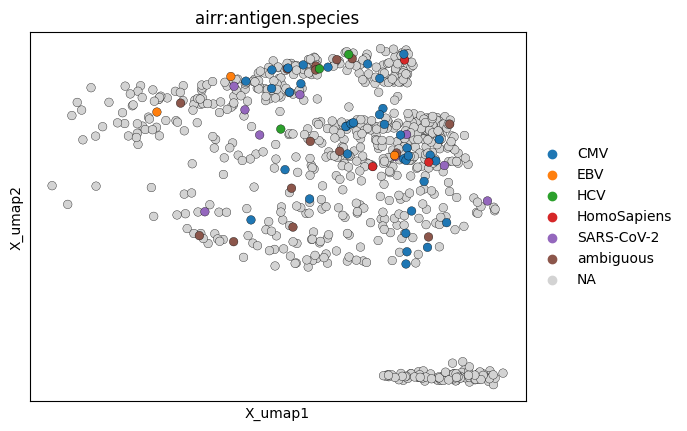

In [112]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata["airr"].obs["epitope_label"] = mdata["airr"].obs["antigen.species"].astype(str) + "(" + mdata["airr"].obs["antigen.gene"].astype(str) +")"
    mdata["airr"].obs["epitope_label"] = mdata["airr"].obs["epitope_label"].astype("category")
    mdata["airr"].obs.sort_values("epitope_label", inplace=True, ascending=False)
    mdata.update_obs()
    mu.pl.embedding(mdata[mask], basis="gex:umap", color="airr:antigen.species", alpha=1, edgecolor="black", linewidth=0.25)

In [78]:
mdata["airr"].obs.loc[new_names.index, "antigen.species"]

cell_id
57                        nan (nan) (nan) (nan)
461                       nan (nan) (nan) (nan)
5845                      nan (nan) (nan) (nan)
8454        HomoSapiens (MLANA) (MLANA) (MLANA)
11221                  CMV (pp65) (pp65) (pp65)
                           ...                 
14021828                  nan (nan) (nan) (nan)
14037912                  nan (nan) (nan) (nan)
14038343                  nan (nan) (nan) (nan)
14040199                  nan (nan) (nan) (nan)
14040636                  nan (nan) (nan) (nan)
Name: antigen.species, Length: 781, dtype: category
Categories (23, object): ['CMV', 'CMV (IE1) (IE1) (IE1)', 'CMV (pp65) (pp65) (pp65)', 'EBV', ..., 'ambiguous', 'ambiguous (ambiguous) (ambiguous) (ambiguous)', 'nan', 'nan (nan) (nan) (nan)']

In [75]:
tmp = mdata["airr"].obs.loc[mask, ["antigen.species", "antigen.gene"]]
new_names = tmp["antigen.species"].astype(str) + " (" +tmp["antigen.gene"].astype(str) + ")"
mdata["airr"].obs["antigen.species"] = mdata["airr"].obs["antigen.species"].astype(str)
mdata["airr"].obs.loc[new_names.index, "antigen.species"] = list(new_names)
mdata["airr"].obs["antigen.species"] = mdata["airr"].obs["antigen.species"].astype("category")

## IEDB

In [ ]:
ir.pp.ir_dist(mdata, iedb, metric="identity", sequence="aa")
ir.tl.ir_query(
    mdata,
    iedb,
    metric="identity",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)

ir.tl.ir_query_annotate(
    mdata,
    iedb,
    metric="identity",
    sequence="aa",
    include_ref_cols=["Epitope Source Molecule", "Epitope Source Organism", "Epitope IEDB IRI"]
)

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


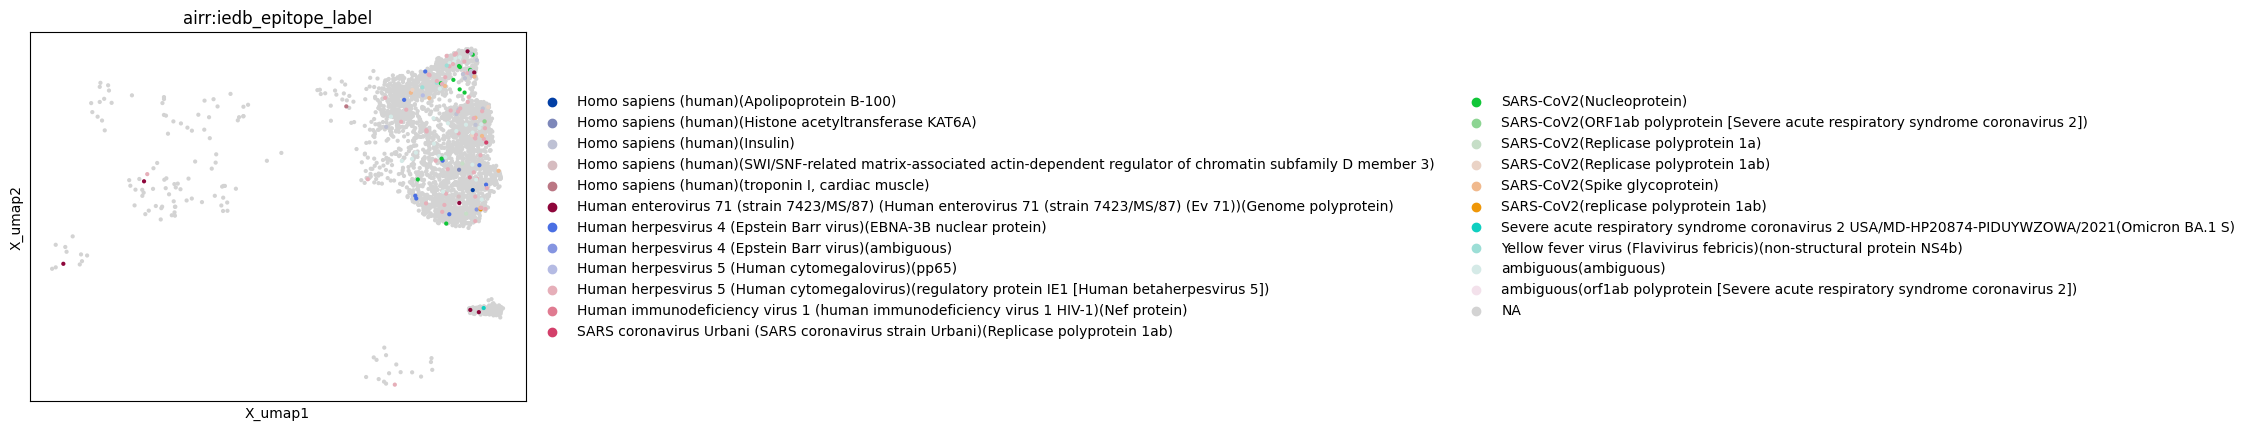

In [7]:
mdata["airr"].obs["iedb_epitope_label"] = (
    mdata["airr"].obs["Epitope Source Organism"] +"(" + mdata["airr"].obs["Epitope Source Molecule"] +")"
)

mdata.update_obs()
mu.pl.embedding(mdata, "gex:umap", color="airr:iedb_epitope_label")

In [9]:
## Split Data into TCR and BCR
mdata_tcr = mdata[mdata["airr"].obs["receptor_type"] == "TCR"].copy()
mdata_bcr = mdata[mdata["airr"].obs["receptor_type"] == "BCR"].copy()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# TCRdist 

In [10]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree

**TCRdist requires complete information of CDR3 and V-gene of both chains.** 

Therefore we will remove and cells with missing variable regions are do not have compelte TCRs

In [11]:
mdata_tcrdist = mdata[
    ~mdata["airr"].obs["chain_pairing"].isin(["No IR", "orphan VDJ", "orphan VJ"])
].copy()

mdata_tcrdist = mdata_tcrdist[mdata_tcrdist.obs["airr:receptor_type"] == "TCR"].copy()

# Filter out cells with variable regions in VJ or VDJ
with ir.get.airr_context(mdata_tcrdist, ["junction_aa", "v_call", "j_call"]):
    for col in ["VJ_1_v_call", "VDJ_1_v_call"]:
        mdata_tcrdist = mdata_tcrdist[~mdata_tcrdist.obs[col].isna()]
    mdata_tcrdist = mdata_tcrdist.copy()

    df_tcrdist = mdata_tcrdist.obs[
        [
            "VJ_1_junction_aa",
            "VJ_1_v_call",
            "VJ_1_j_call",
            "VDJ_1_junction_aa",
            "VDJ_1_v_call",
            "VDJ_1_j_call",
            "airr:chain_pairing",
            "gex:ID",
            "airr:antigen.species",
            "gex:consensus_celltype",
        ]
    ].copy()

for col in df_tcrdist.columns:
    df_tcrdist[col] = df_tcrdist[col].astype(str)
df_tcrdist = df_tcrdist.drop_duplicates()
df_tcrdist = df_tcrdist.reset_index(drop=True)

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


**Rename the columns to be compatbile wiht tcrDIST object**


In [12]:
dict_rename_tcrdist = {
    "VJ_1_junction_aa": "cdr3_a_aa",
    "VJ_1_v_call": "v_a_gene",
    "VDJ_1_junction_aa": "cdr3_b_aa",
    "VDJ_1_v_call": "v_b_gene",
}

df_tcrdist = df_tcrdist.rename(columns=dict_rename_tcrdist)

df_tcrdist["v_a_gene"] = df_tcrdist["v_a_gene"].astype(str)
df_tcrdist["v_b_gene"] = df_tcrdist["v_b_gene"].astype(str)

df_tcrdist["count"] = 1  # todo

df_tcrdist["index"] = df_tcrdist.index

### TCR repertoire object, that will contain the pairwise distances between all TCRs.
- Don't forget to update the orgnasim

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tr = TCRrep(cell_df=df_tcrdist, organism="human", chains=["alpha", "beta"])

In [14]:
dist_total = tr.pw_alpha + tr.pw_beta
columns = tr.clone_df["index"].astype(float).astype(int)
df_dist = pd.DataFrame(dist_total, columns=columns, index=columns)

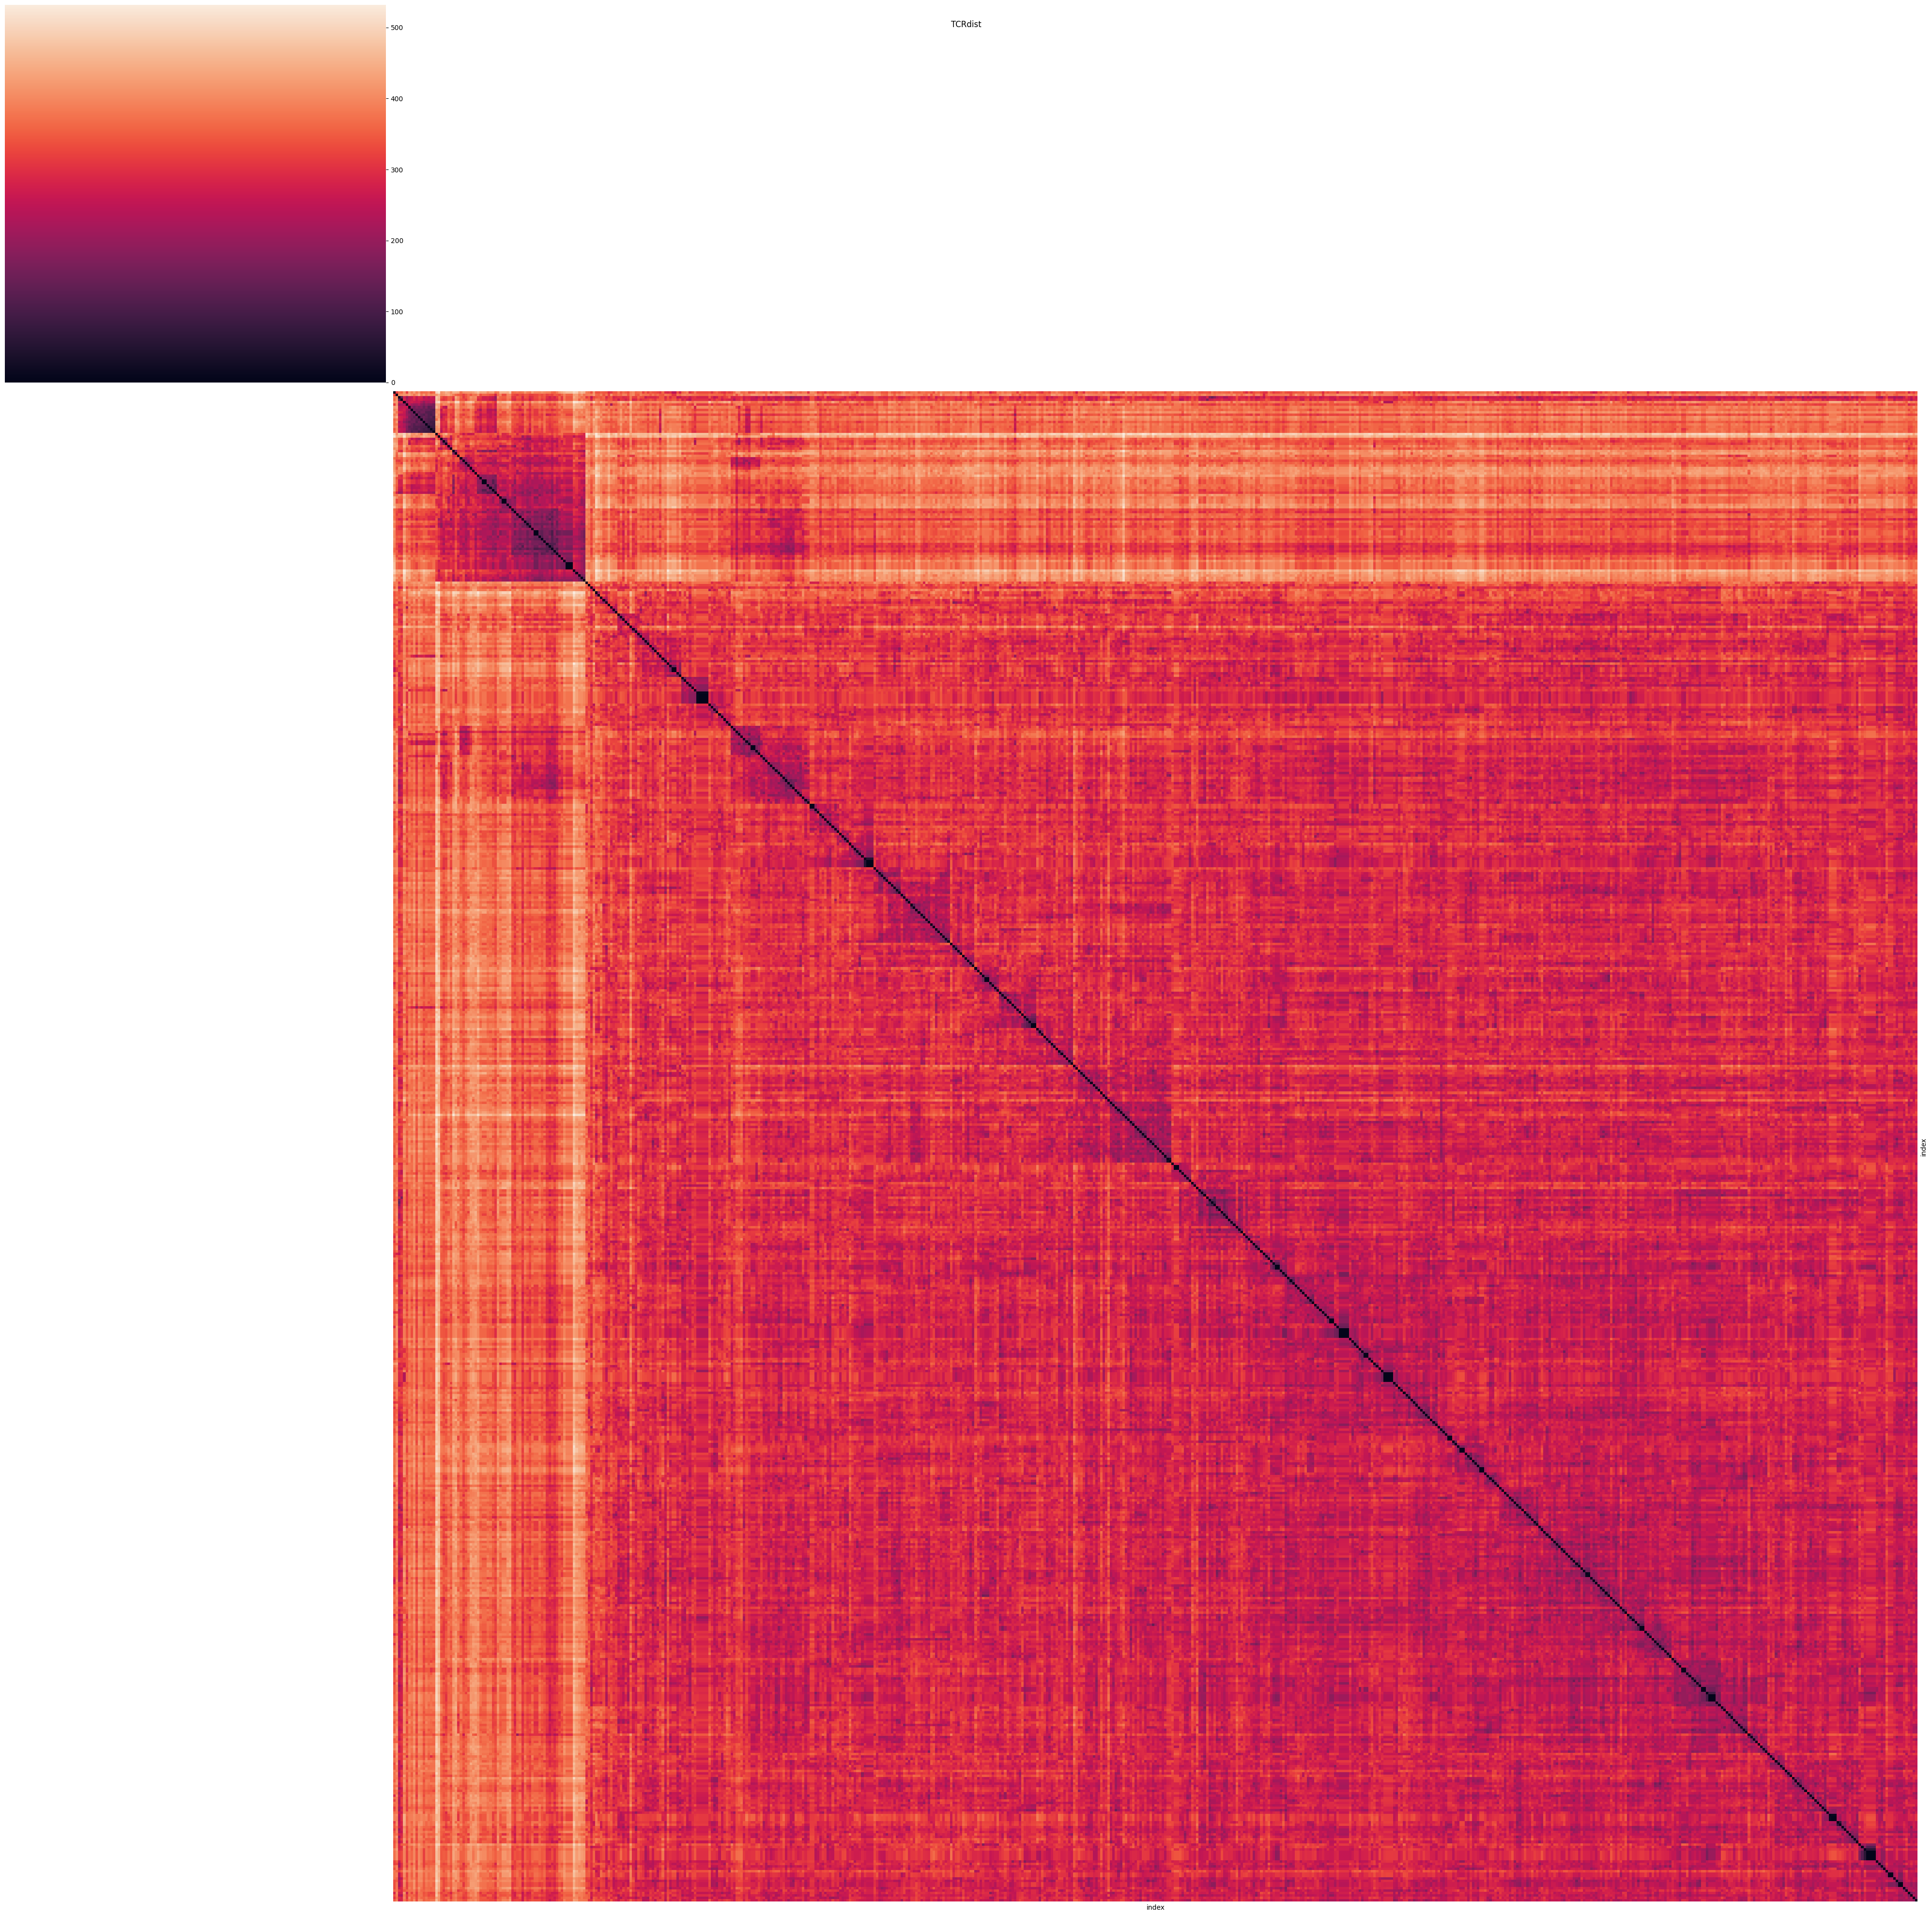

In [15]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from matplotlib import rcParams

rcParams["figure.figsize"] = (20, 20)

linkage = hc.linkage(sp.distance.squareform(df_dist), method="average")
plot = sns.clustermap(
    df_dist,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=(40, 40),
    yticklabels=False,
    xticklabels=False,
)
plot.ax_row_dendrogram.set_visible(False)
plot.ax_col_dendrogram.set_visible(False)

plot.fig.suptitle("TCRdist")
plt.tight_layout()

In [16]:
df_tcrdist_alpha = pd.DataFrame(
    tr.pw_alpha, columns=tr.clone_df["cdr3_a_aa"], index=tr.clone_df["cdr3_a_aa"]
)
df_tcrdist_beta = pd.DataFrame(
    tr.pw_beta, columns=tr.clone_df["cdr3_b_aa"], index=tr.clone_df["cdr3_b_aa"]
)


**add_dist**

Overall, it stores the name of distance, the sequences, and the pairwise distances to adata.uns. To store the pairwise distances efficiently in a sparse matrix, all entries above a user-defined cutoff (here: 60 per chain, since a commonly used TCRdist cutoff is 120) will be set to 0, and all other distances are shifted by 1 (i.e. perfect matches will have a distance of 1).

In [17]:
from scipy.sparse import csr_matrix


def add_dists(adata, df_dist_alpha, df_dist_beta, name, cutoff):
    """
    Adds processed distance matrices for alpha and beta chains to an AnnData object.

    Parameters:
    adata (AnnData): Target AnnData object for distance matrix addition.
    df_dist_alpha (pd.DataFrame or None): DataFrame with alpha chain distances; skipped if None.
    df_dist_beta (pd.DataFrame or None): DataFrame with beta chain distances; skipped if None.
    name (str): Name identifier for the metric used in distance calculations.
    cutoff (int or float): Cutoff threshold; distances greater than this value are set to zero.

    Notes:
    - Distance matrices are adjusted (incremented by 1, truncated using cutoff) and stored as csr_matrix in `adata.uns`.
    - Function modifies `adata` in-place, adding a key for each chain with sequences and processed distances.
    """

    adata.uns[f"ir_dist_aa_{name}"] = {
        "params": {"metric": f"{name}", "sequence": "aa", "cutoff": cutoff}
    }

    for chain, dists in [("VJ", df_dist_alpha), ("VDJ", df_dist_beta)]:
        if dists is None:
            continue
        dist_values = dists.values + 1
        dist_values[dist_values > (cutoff + 1)] = 0
        dist_values = csr_matrix(dist_values)
        adata.uns[f"ir_dist_aa_{name}"][chain] = {
            "seqs": dists.index.tolist(),
            "distances": dist_values,
        }


add_dists(mdata_tcrdist["airr"], df_tcrdist_alpha, df_tcrdist_beta, "tcrdist", 60)

In [18]:
vj_seqs = mdata_tcrdist["airr"].uns["ir_dist_aa_tcrdist"]["VJ"]["seqs"]
vdj_seqs = mdata_tcrdist["airr"].uns["ir_dist_aa_tcrdist"]["VDJ"]["seqs"]

mdata_tcrdist = mdata_tcrdist[mdata_tcrdist.obs["VJ_1_junction_aa"].isin(vj_seqs)]
mdata_tcrdist = mdata_tcrdist[mdata_tcrdist.obs["VDJ_1_junction_aa"].isin(vdj_seqs)]

ir.tl.define_clonotype_clusters(
    mdata_tcrdist["airr"],
    sequence="aa",
    metric="tcrdist",
    receptor_arms="all",
    dual_ir="primary_only",
)

  0%|          | 0/586 [00:00<?, ?it/s]

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scirpy/util/__init__.py:187: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self.data.obs[key] = value
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<Axes: >

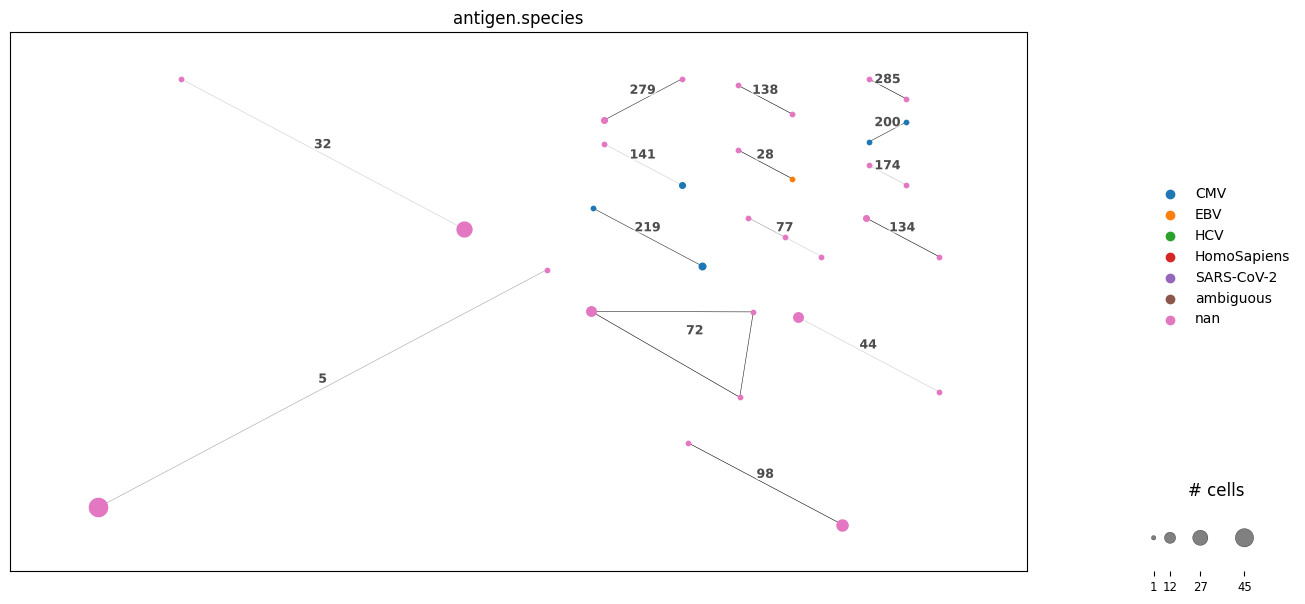

In [19]:
mdata_tcrdist["airr"].obs["antigen.species"] = mdata_tcrdist["airr"].obs["antigen.species"].astype(str)

ir.tl.clonotype_network(
    mdata_tcrdist["airr"], min_cells=1, min_nodes=2, sequence="aa", metric="tcrdist"
)
ir.pl.clonotype_network(
    mdata_tcrdist["airr"],
    color="antigen.species",
    label_fontsize=9,
    panel_size=(14, 7),
    base_size=10,
    size_power=0.75,
)

In [20]:
mdata_tcrdist.obs[["VJ_1_junction_aa", "VDJ_1_junction_aa", "airr:antigen.species", "airr:antigen.epitope"]][mdata_tcrdist["airr"].obs["cc_aa_tcrdist"] == "72"]

,VJ_1_junction_aa,VDJ_1_junction_aa,airr:antigen.species,airr:antigen.epitope
1349443,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
1360554,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
1492320,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
4004814,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
4720929,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
8711885,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
9163094,CVVSAKAAGNKLTL,CASSIVQMNTGELFF,NaN,NaN
11810783,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
12255796,CVVNAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN
13734204,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,NaN,NaN


# TCRmatch
- TCRmatch requires only the CDR3β of the TCR.
-  It can therefore use a wider array of data, since especially less recent studies focused mainly on measuring the β-chain. 

In [21]:
## Filter Cells without a beta chain
mdata_tcrmatch = mdata_tcr[
    ~mdata_tcr.obs["airr:chain_pairing"].isin(["No IR", "orphan VJ", "multi_chain"])
]


with ir.get.airr_context(mdata_tcrmatch, ["junction_aa", "v_call", "j_call"]):
    mdata_tcrmatch = mdata_tcrmatch[
        ~mdata_tcrmatch.obs["VDJ_1_junction_aa"].isna()
    ].copy()
    
df_tcrmatch = mdata_tcrmatch.obs[["VDJ_1_junction_aa", "airr:antigen.species"]].copy()
df_tcrmatch = df_tcrmatch.drop_duplicates()
df_tcrmatch = df_tcrmatch.reset_index(drop=True)
len(df_tcrmatch)

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1532

tcrMatch method uses a Text-File as input, containing **only the β-chain**, without leading C and ending F or W as provided by the Cell Ranger output. We therefore need to adjust our data accordingly.

In [22]:
import os
tmp_dir = "tcrMatch"
if tmp_dir not in os.listdir():
    os.mkdir(tmp_dir)
    
df_tcrmatch["CDR3b_trimmed"] = df_tcrmatch["VDJ_1_junction_aa"].str[1:-1]
df_tcrmatch[["CDR3b_trimmed"]].to_csv(
    f"{tmp_dir}/tcrmatch_input.csv", header=False, index=False
)
df_tcrmatch["CDR3b_trimmed"].to_csv(
    f"{tmp_dir}/tcrmatch_db.csv", header=False, index=False
)

### Run tcrMATCH
[Program Link](https://github.com/IEDB/TCRMatch)\\


- The easiest way to run this program is to use a Docker and run it there. This way we don't have to worry about dependency issues.

In [23]:
dist_tcrmatch = pd.read_csv(f"{tmp_dir}/tcrmatch_output.csv", sep="\t")
dist_tcrmatch = dist_tcrmatch[["trimmed_input_sequence", "match_sequence", "score"]]
dist_tcrmatch = dist_tcrmatch.drop_duplicates()
dist_tcrmatch = dist_tcrmatch.pivot(columns="trimmed_input_sequence", index="match_sequence", values="score")
values = 1 - (dist_tcrmatch.values + dist_tcrmatch.values.transpose()) / 2

trimmed_2_full = dict(df_tcrmatch[["CDR3b_trimmed", "VDJ_1_junction_aa"]].values)
columns = dist_tcrmatch.index.map(trimmed_2_full)
dist_tcrmatch = pd.DataFrame(index=columns, columns=columns, data=values)
dist_tcrmatch = dist_tcrmatch.fillna(1)
dist_tcrmatch.index.name = None
dist_tcrmatch.head(5)

,CAARGASNGEKLFF,CACDAGGGTDKLIF,CACDAGGLHTDKLIF,CACDALGDSERDKLIF,CACDATGGSGTWDTRQMF,CACDGVGKTSDKLIF,CACDKFRGSWDTRQMF,CACDKLGDTSYTDKLIF,CACDLIGGFPDKLIF,CACDMIGGGHTDKLIF,...,CSVLLQQGATFF,CSVLPGPGETQYF,CSVNAKYARETQYF,CSVRDRGDEQYF,CSVRDRGEKLFF,CSVSPQGKQPQHF,CSVVAGGYNEQFF,CSVVLAGRMNTGELFF,CTSSQRTDQPHYEQYF,CTTETGSCGNYGYTF
CAARGASNGEKLFF,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CACDAGGGTDKLIF,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CACDAGGLHTDKLIF,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CACDALGDSERDKLIF,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CACDATGGSGTWDTRQMF,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


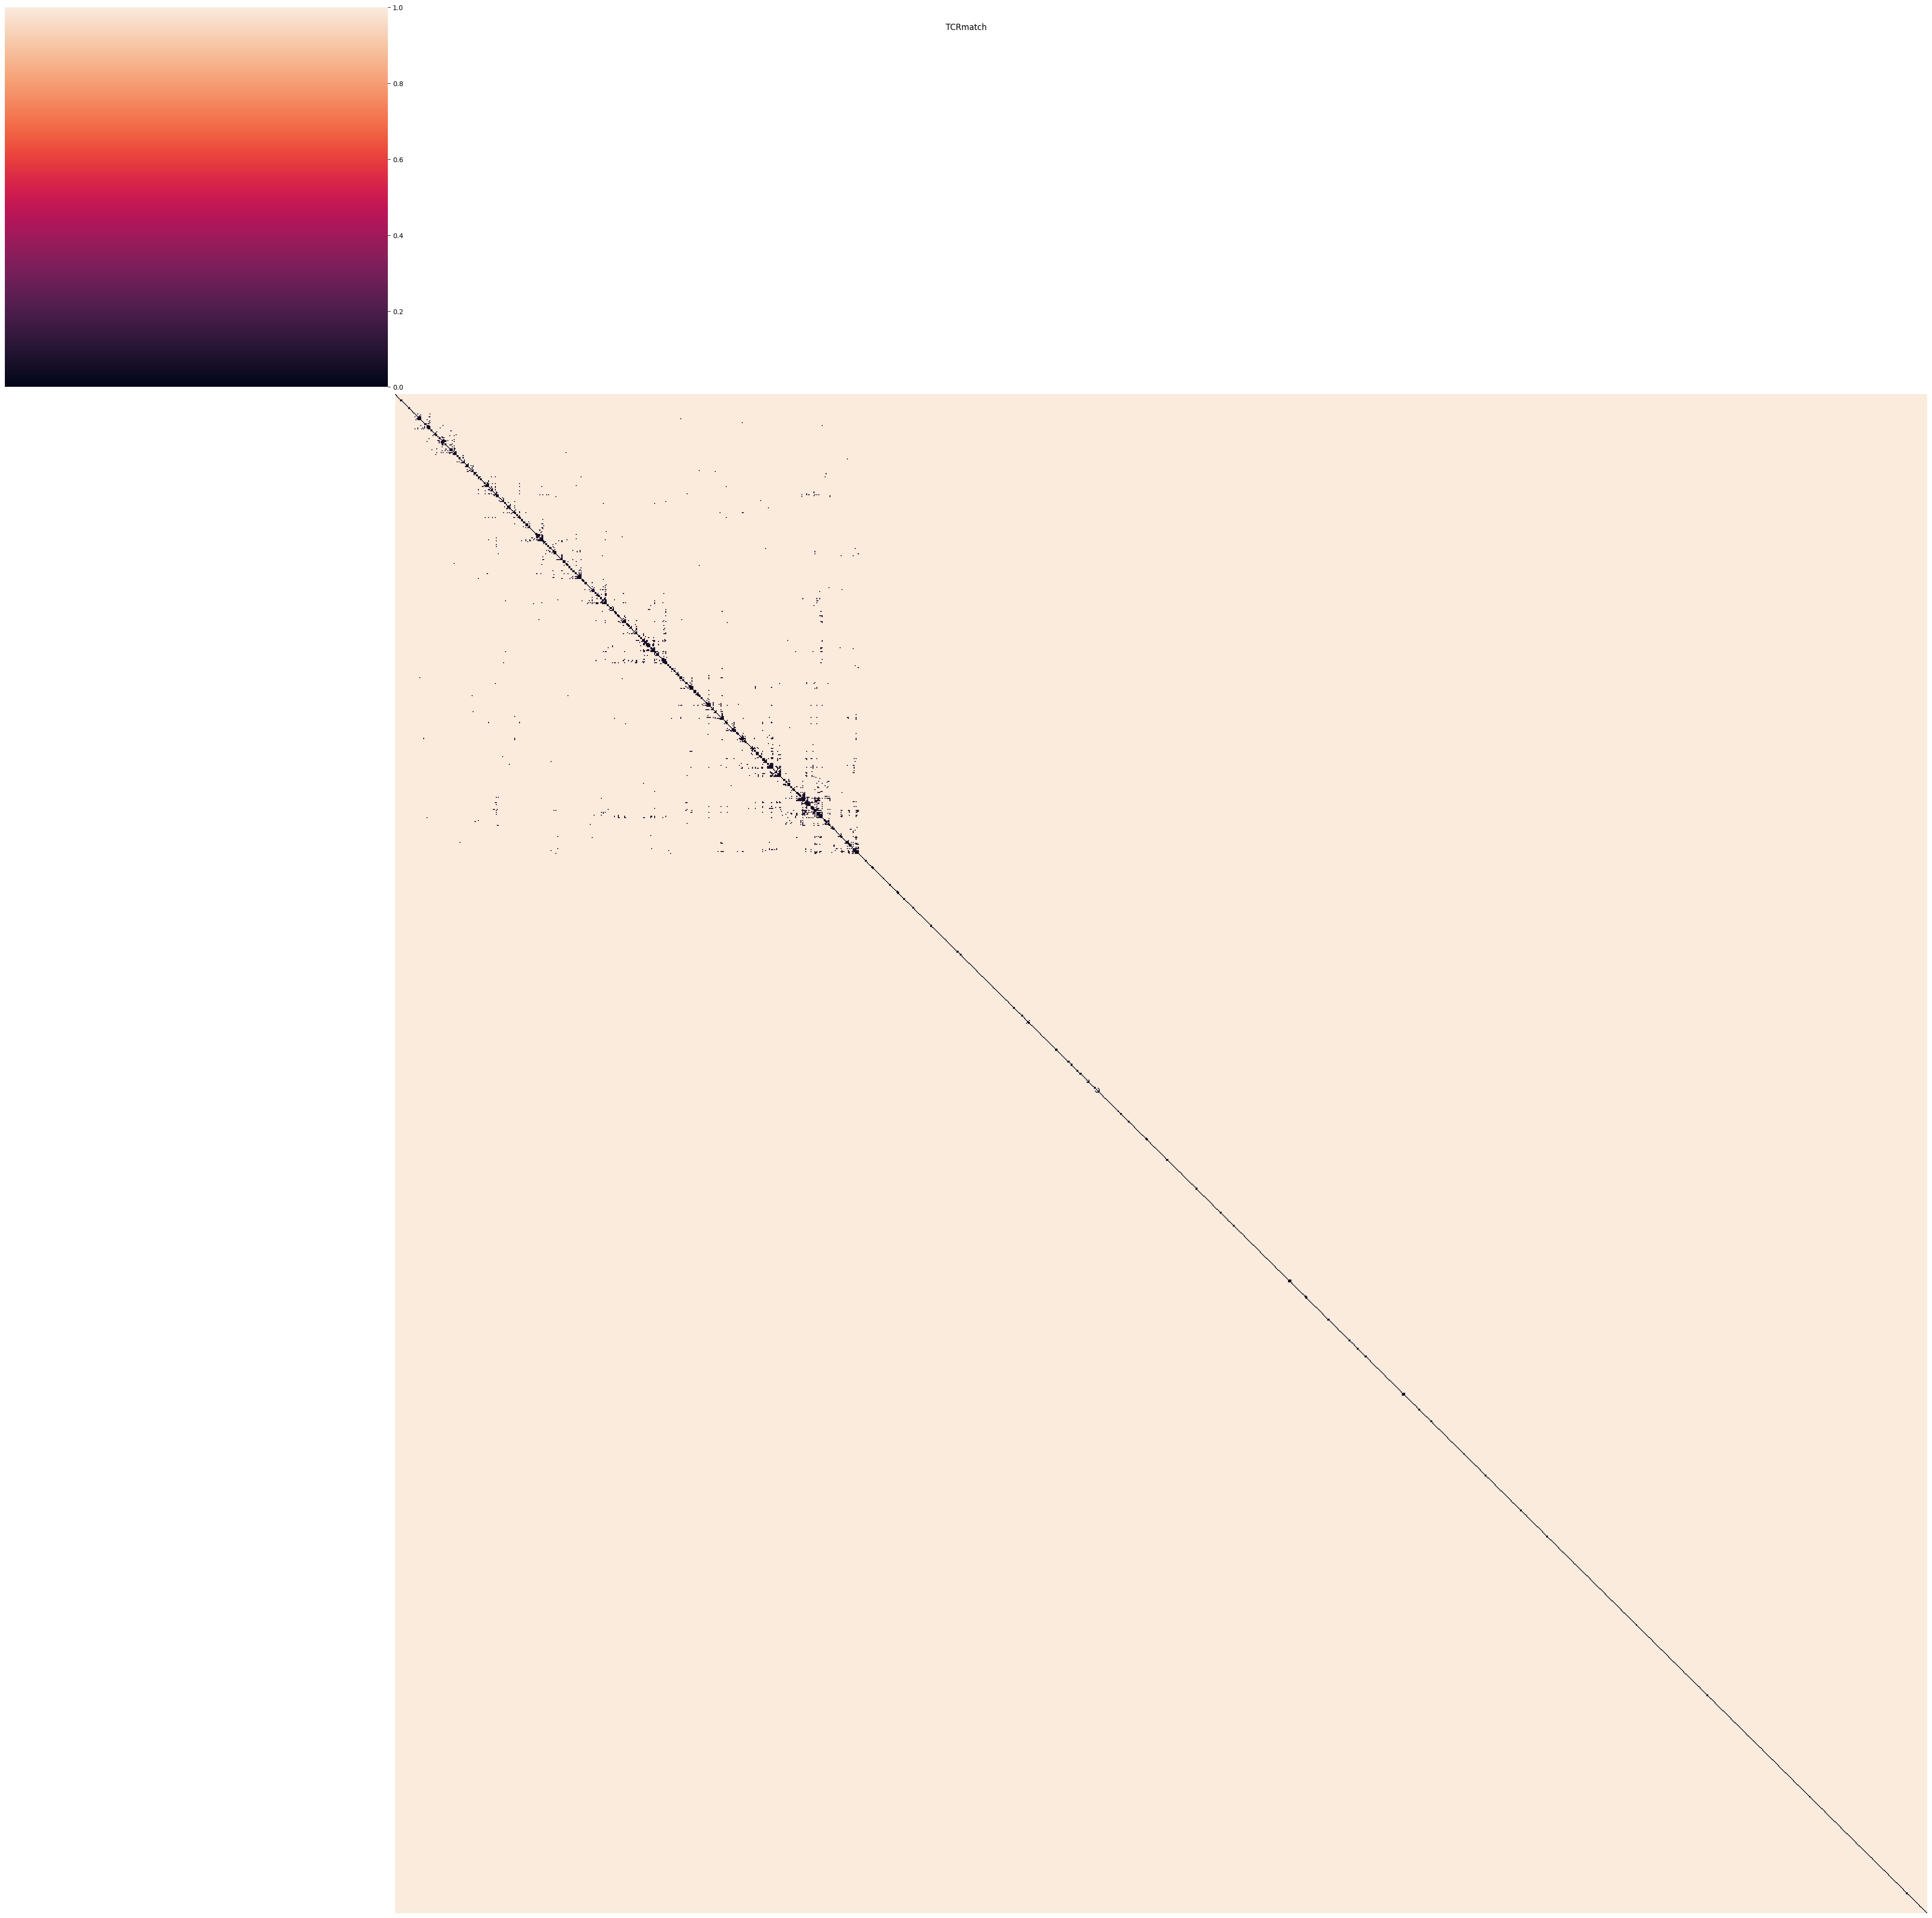

In [24]:
linkage = hc.linkage(sp.distance.squareform(dist_tcrmatch), method="average")
plot = sns.clustermap(
    dist_tcrmatch,
    row_linkage=linkage,
    col_linkage=linkage,
    figsize=(40, 40),
    yticklabels=False,
    xticklabels=False,
)
plot.ax_row_dendrogram.set_visible(False)
plot.ax_col_dendrogram.set_visible(False)
plot.fig.suptitle("TCRmatch")
plt.tight_layout()

In [84]:
add_dists(mdata_tcrmatch["airr"], None, dist_tcrmatch, "tcrmatch", 0.065)

  0%|          | 0/1520 [00:00<?, ?it/s]

<Axes: >

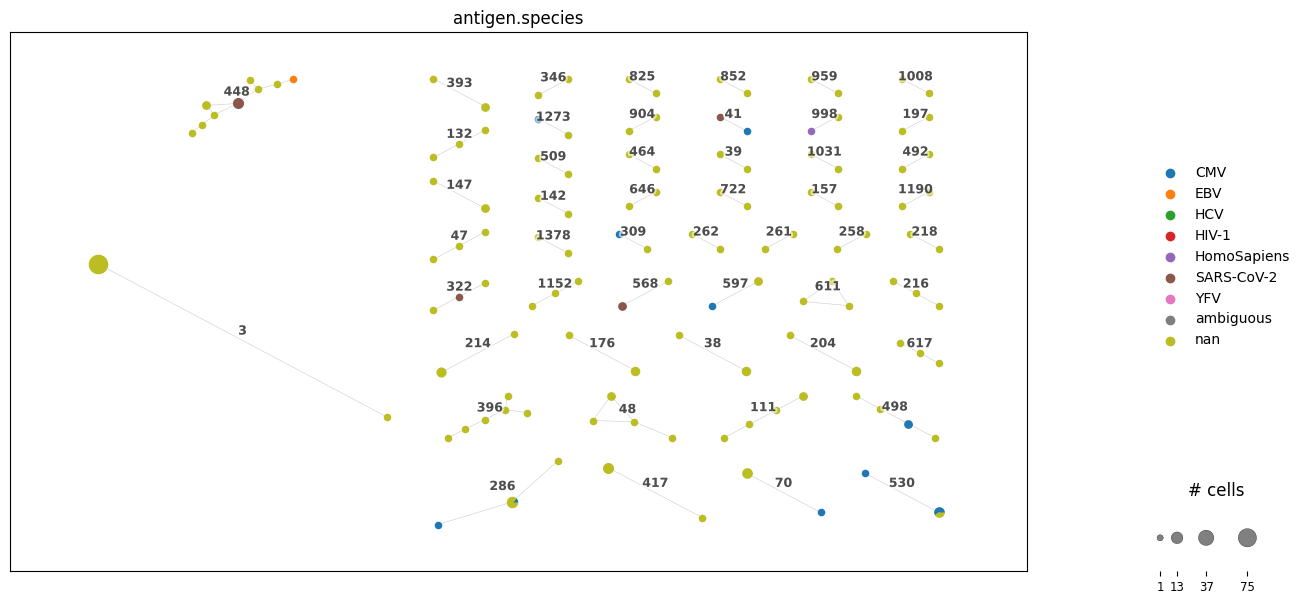

In [88]:
ir.tl.define_clonotype_clusters(
    mdata_tcrmatch["airr"],
    sequence="aa",
    metric="tcrmatch",
    receptor_arms="VDJ",
    dual_ir="primary_only",
)
ir.tl.clonotype_network(
    mdata_tcrmatch["airr"], min_cells=1, min_nodes=2, sequence="aa", metric="tcrmatch"
)

mdata_tcrmatch["airr"].obs["antigen.species"] = mdata_tcrmatch["airr"].obs["antigen.species"].astype(str)
ir.pl.clonotype_network(
    mdata_tcrmatch["airr"],
    color="antigen.species",
    label_fontsize=9,
    panel_size=(14, 7),
    base_size=20,
    size_power=0.5,
)

In [99]:
def get_clonal_clusters(mdata, clone_id, clone_key="airr:cc_aa_alignment"):
    mdata = mdata.copy()
    mdata.update()
    with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
        df = (
            # TODO astype(str) is required due to a bug in pandas ignoring `dropna=False`. It seems fixed in pandas 2.x
            mdata.obs.loc[lambda x: x[clone_key] == clone_id]
            .astype(str)
            .groupby(
                [
            
                    "VDJ_1_junction_aa",
                    "VDJ_1_v_call",
                    "airr:receptor_subtype",
                    "airr:antigen.species",
                    "airr:antigen.epitope",
                    "gex:consensus_celltype",
                ],
                observed=True,
                dropna=False,
            )
            .size()
            .reset_index(name="n_cells")
        )
    return df

In [100]:
get_clonal_clusters(mdata_tcrmatch, clone_id="498", clone_key="airr:cc_aa_tcrmatch")

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,VDJ_1_junction_aa,VDJ_1_v_call,airr:receptor_subtype,airr:antigen.species,airr:antigen.epitope,gex:consensus_celltype,n_cells
0,CASALVGTEAFF,TRBV12-4*01,TRA+TRB,nan,nan,CD4 Memory,1
1,CASSLAGSEAFF,TRBV7-9*03,ambiguous,nan,nan,CD8 Memory,1
2,CASSLRGTEAFF,TRBV11-3*01,TRA+TRB,CMV,KLGGALQAK,CD8 Memory,1
3,CASSLRGTEAFF,TRBV27*01,TRA+TRB,CMV,KLGGALQAK,CD4 Memory,1
4,CASSSVRGTEAFF,TRBV6-6*02,TRA+TRB,nan,nan,CD4 Memory,1
